# GARCH-inspire latent volatility model

::: {.callout-note}
Generative AI was used to fix grammar in the writing. The rest is done by me.
:::

In the previous post I built a very simple model to demonstrate how log return dynamics can be learnt from previous noisy observations of observed returns. The real problem of that approach was that variance was assumed to be something observed, whereas it is clear that variance is not something we measure directly. 

We do not measure log returns either, but those were sampled, so we assumed we do not know them. In this post I’m actually going to switch to modelling latent volatility, which is supposedly a better way to build this sort of model.

Running a bit ahead of myself, I do think that this sort of modelling leads to better and more reasonable models, but quantifying these statements is something we will deal with later on. 

This articles describes in details the following flow:

```{mermaid}
flowchart TD
    A[Historical Prices & Features] --> B[Feature Engineering]
    B --> C[Past Returns and Variances]
    C --> D[Latent Volatility Sampling]
    D --> E[Log Return Sampling]
    E --> F[Reconstruct Price Path]
    F --> H[Output Price Path Simulation]
```

In [1]:
# | exporti


import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy.typing as npt
import numpyro
import numpyro.distributions as dist
import polars as pl
import seaborn as sns
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from tqdm import tqdm
from bayesianfin.simulation import Simulator
from bayesianfin.data import (
    QuantileTransformer,
    DataLoader,
    FeatureEngineer,
    LogReturn,
    Variance,
    Identity,
)

In [2]:
# | export
az.style.use("arviz-darkgrid")

## Data loading

We start by loading the data, and examining the returns, log-return distribution, as well as variance plots. The dataset we are using today contains heating oil prices from 2010 until May, 2025. The dataset was pulled from [investing.com](https://uk.investing.com/commodities/heating-oil).

In [3]:
source_df = (
    pl.read_csv(
        "./data/heating_oil.csv",
        infer_schema_length=0,
        dtypes={"Price": pl.Utf8},
        columns=["Date", "Price"],
    )
    .with_columns(
        pl.col("Date").str.to_date(format="%m/%d/%Y"),
        pl.col("Price").str.replace_all(",", "").cast(pl.Float64),
    )
    .rename({"Date": "date", "Price": "price"})
    .with_columns(
        ret=pl.col("price") / pl.col("price").shift(1),
    )
).sort("date")
source_df.head()

/var/folders/8s/q13s1_m56g3b3k_1fmdrwn_80000gn/T/ipykernel_89914/1155920622.py:2: DeprecationWarning: The argument `dtypes` for `read_csv` is deprecated. It has been renamed to `schema_overrides`.
  pl.read_csv(


date,price,ret
date,f64,f64
2010-04-05,2.2825,0.998775
2010-04-06,2.2853,1.010703
2010-04-07,2.2611,1.007396
2010-04-08,2.2445,1.000401
2010-04-09,2.2436,1.002771


## Feature extraction

The class below is implemented to ease off the data analysis and handling. It produces lagged features for returns and variances, as well as transforms the data so it is easier to feed into a model.

In [4]:
# | exec: false
feature_engineer = FeatureEngineer(
    transforms=[
        LogReturn(source_field="ret", feature_name="log_ret"),
        Variance(
            source_field="price",
            feature_name="var",
            rolling_variance_window=2,
        ),
        LogReturn(source_field="var", feature_name="log_var", requested_lag=0),
        QuantileTransformer(source_field="var", feature_name="var_quantile"),
    ],
    n_shifts=3,
)
df_with_features = feature_engineer.create_features(source_df)
df_with_features.head()

date,price,ret,log_ret,var,log_var,var_quantile,prev_log_ret_1,prev_log_ret_2,prev_log_ret_3,prev_var_1,prev_var_2,prev_var_3,prev_var_quantile_1,prev_var_quantile_2,prev_var_quantile_3
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-04-09,2.2436,1.002771,0.002767,0.0001,-9.21034,0.0,0.000401,0.007369,0.010646,0.000138,0.000293,0.0001,0.388388,0.53155,0.0
2010-04-12,2.2374,1.001791,0.001789,0.0001,-9.21034,0.0,0.002767,0.000401,0.007369,0.0001,0.000138,0.000293,0.0,0.388388,0.53155
2010-04-13,2.2334,0.987531,-0.012547,0.0001,-9.21034,0.0,0.001789,0.002767,0.000401,0.0001,0.0001,0.000138,0.0,0.0,0.388388
2010-04-14,2.2616,0.994591,-0.005424,0.000398,-7.830014,0.596285,-0.012547,0.001789,0.002767,0.0001,0.0001,0.0001,0.0,0.0,0.0
2010-04-15,2.2739,1.015406,0.015288,0.0001,-9.21034,0.0,-0.005424,-0.012547,0.001789,0.000398,0.0001,0.0001,0.596285,0.0,0.0


(-1.0, 2.0)

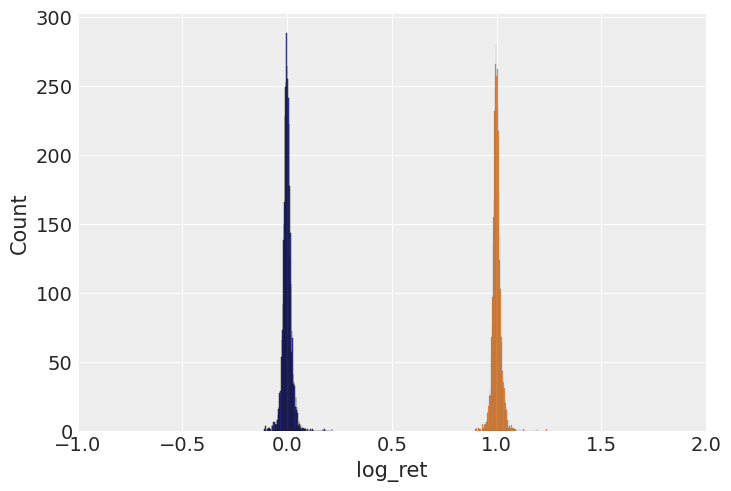

In [5]:
sns.histplot(df_with_features, x="log_ret")
sns.histplot(df_with_features, x="ret")
plt.xlim([-1, 2])

<Axes: xlabel='date', ylabel='log_ret'>

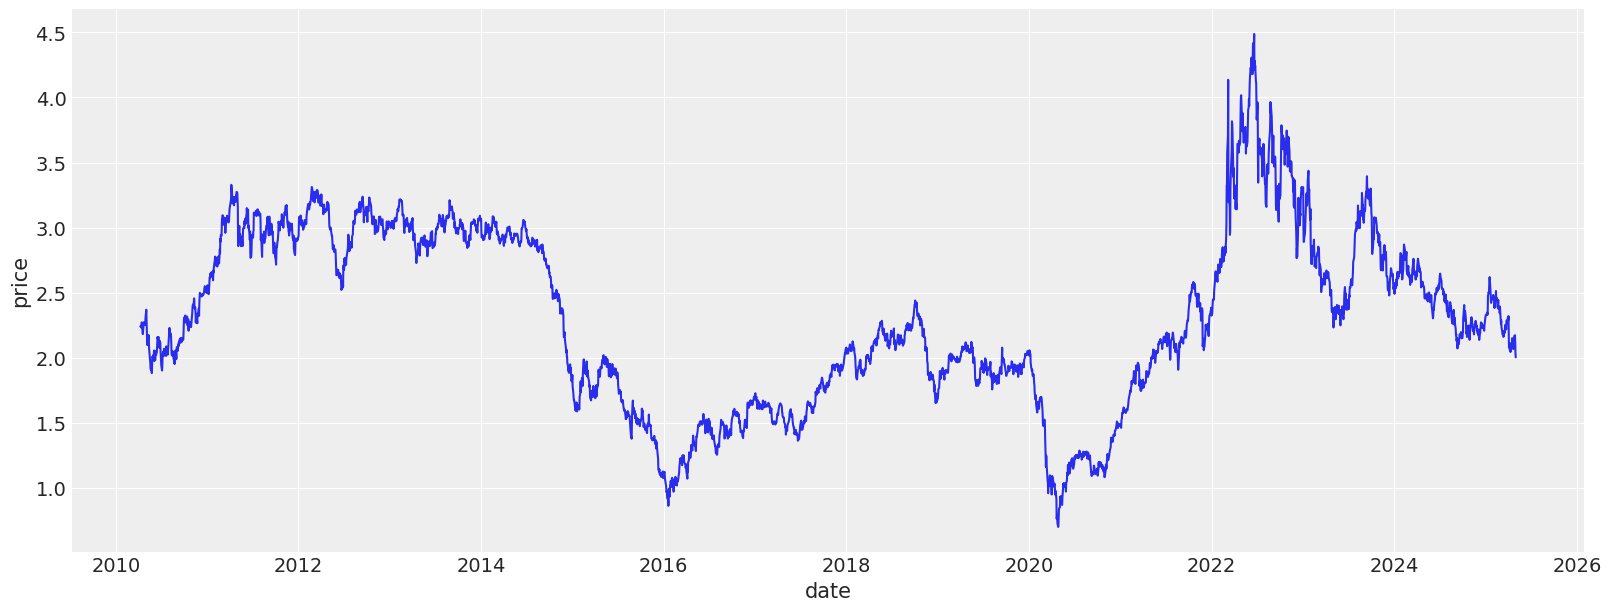

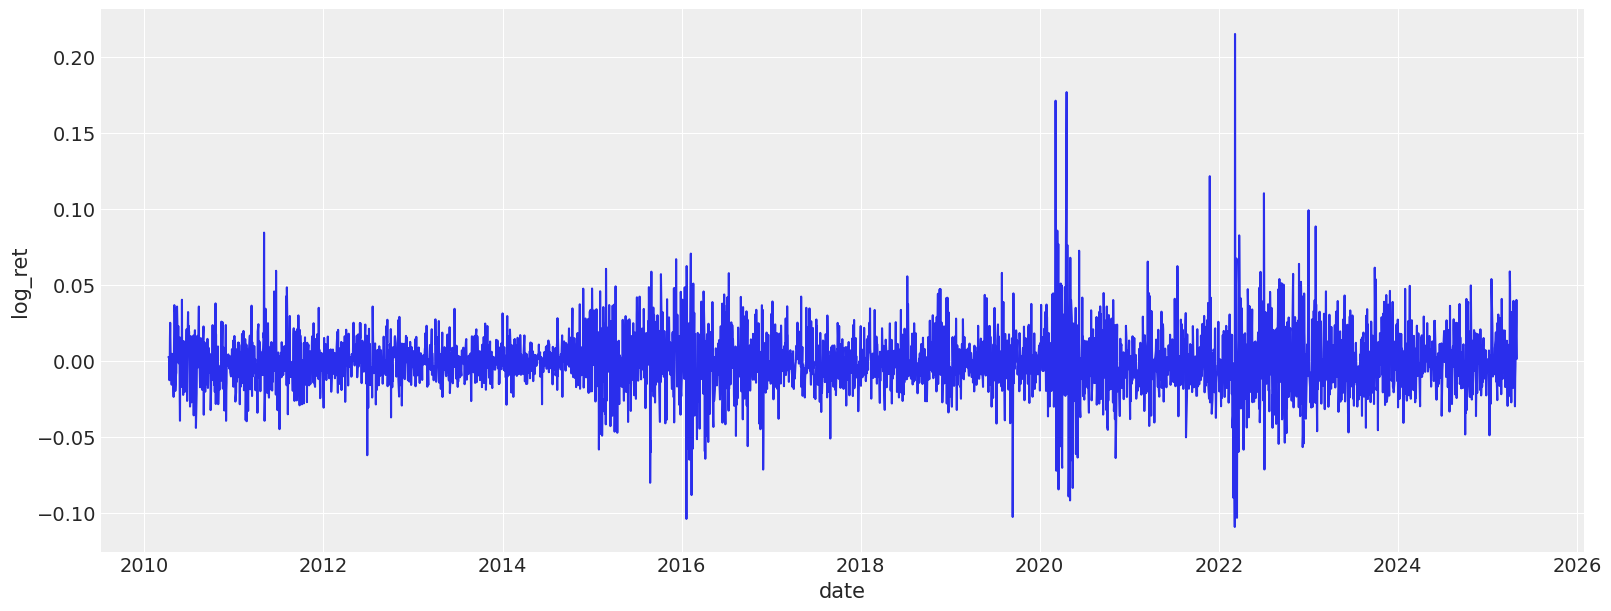

In [6]:
plt.figure(figsize=(16, 6))
sns.lineplot(df_with_features, x="date", y="price")
plt.figure(figsize=(16, 6))
sns.lineplot(df_with_features, x="date", y="log_ret")

## The model

I will now demonstrate how one can build a latent volatility model that can then be used to sample new observations in an autoregressive manner. The main change here is that the volatility is not a linear function anymore, like it used to be, but it is a latent variable sampled along with the log return. Still, a limitation remains for this model that we do condition our latent volatility on the observed noisy variable. Worth noting, that we assume a latent volatility variable per time step, meaning we will end up with a latent volatility variable that has the length of the original time series. 

As before, the log return is sampled from Student T distribution so account for potentially heavier tails. Other than that, we still use Monte Carlo to build an idea for posterior distributions. Despite a relatively long time series, the below model sampling is quite efficient, so should converge fast.


In [7]:
# Cut-off point
T = 300
present_value_log_ret, present_value_log_var, present_value_test = (
    df_with_features["log_ret"][:-T].to_numpy(),
    df_with_features["log_var"][:-T].to_numpy(),
    df_with_features["log_ret"][-T:].to_numpy(),
)
past_values_train, past_values_test = (
    feature_engineer.to_numpy_dict(df_with_features[:-T]),
    feature_engineer.to_numpy_dict(df_with_features[-T:]),
)

In [ ]:
# | export
def garch_like_sample_vol_model(
    value_log_ret: npt.NDArray = None,
    log_var_value: npt.NDArray = None,
    past_values: dict[str, npt.NDArray] = None,
) -> None:
    def_spread = 0.5
    b_var = numpyro.sample("b_var", dist.Normal(0, def_spread))

    coeffs = {}

    for col, s in feature_engineer.get_iterator("var_quantile"):
        param_name = feature_engineer.get_shift_pattern(col, s)
        coeffs[param_name] = numpyro.sample(
            f"param_{param_name}", dist.Normal(0.0, def_spread)
        )

    len_observations = len(value_log_ret) if value_log_ret is not None else 1
    with numpyro.plate("data", len_observations):
        mu_log_var = b_var
        for col, s in feature_engineer.get_iterator("var_quantile"):
            param_name = feature_engineer.get_shift_pattern(col, s)
            mu_log_var += coeffs[param_name] * past_values[param_name]

        log_var = numpyro.sample(
            "log_var", dist.Normal(mu_log_var, 0.1), obs=log_var_value
        )
        std = jnp.exp(log_var / 2)
        # Condition on observed values if provided
        numpyro.deterministic("log_ret_var", log_var)
        numpyro.sample("log_ret", dist.Normal(0, std), obs=value_log_ret)


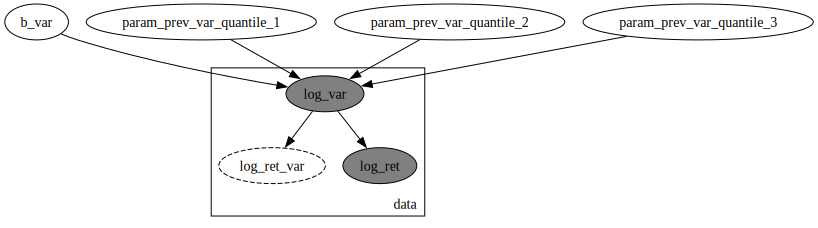

In [18]:
numpyro.render_model(
    garch_like_sample_vol_model,
    model_args=(
        present_value_log_ret,
        present_value_log_var,
        past_values_train,
    ),
)

In [9]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(garch_like_sample_vol_model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)

mcmc.run(
    rng_key_,
    present_value_log_ret,
    present_value_log_var,
    past_values_train,
)
mcmc.print_summary()
posterior_samples = mcmc.get_samples()
print(posterior_samples.keys())

sample: 100%|██████████| 3000/3000 [00:01<00:00, 1735.54it/s, 15 steps of size 2.39e-01. acc. prob=0.94]



                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
                      b_var     -8.62      0.00     -8.62     -8.63     -8.61   1404.51      1.00
  param_prev_var_quantile_1      0.58      0.00      0.58      0.57      0.59   1525.50      1.00
  param_prev_var_quantile_2      0.41      0.00      0.41      0.40      0.42   1554.38      1.00
  param_prev_var_quantile_3      0.46      0.00      0.46      0.46      0.47   1521.64      1.00

Number of divergences: 0
dict_keys(['b_var', 'log_ret_var', 'param_prev_var_quantile_1', 'param_prev_var_quantile_2', 'param_prev_var_quantile_3'])


## Post-fitting checks

In [ ]:
posterior_samples = mcmc.get_samples()
predictive = Predictive(
    garch_like_sample_vol_model,
    posterior_samples=posterior_samples,
    return_sites=["log_ret"],  # or whatever your observation site is called
)
rng_key, rng_key_ppc = random.split(rng_key)
ppc_samples = predictive(
    rng_key_ppc,
    present_value_log_ret,
    present_value_log_var,
    past_values_train,
)
prior_samples = Predictive(garch_like_sample_vol_model, num_samples=2000)(
    rng_key,
    present_value_log_ret,
    present_value_log_var,
    past_values_train,
)

idata = az.from_numpyro(mcmc, posterior_predictive=ppc_samples, prior=prior_samples)

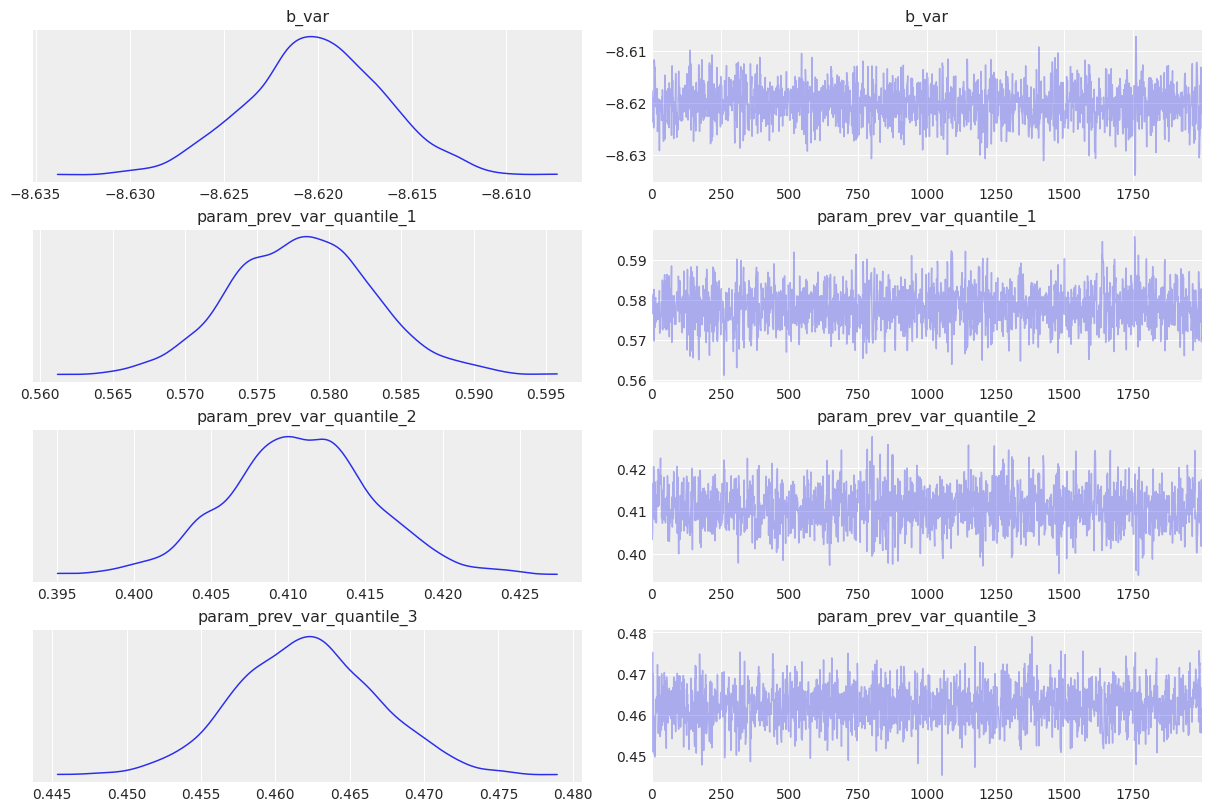

In [11]:
az.plot_trace(idata, var_names=["~^log_ret_var"], filter_vars="regex");

## Future paths simulations

Finally, we are able to run the autoregressive simulation and look at the distribution of the final prices. Let’s look at the average sample error for each of the run id. We then can compare the average spread relative to the 


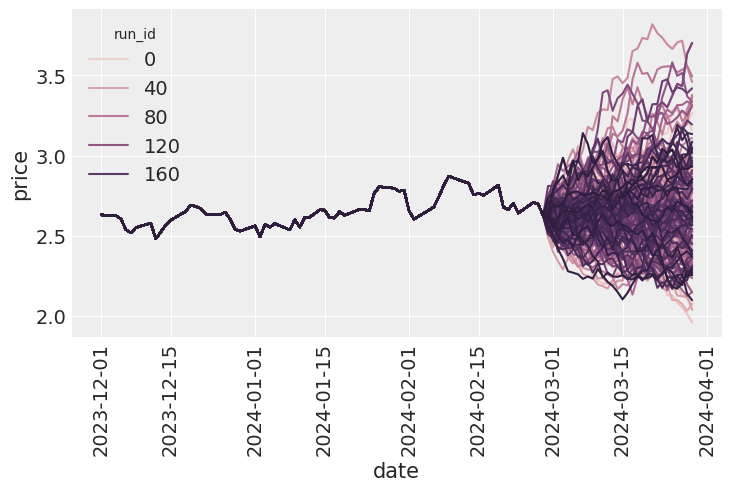

In [12]:
simulator = Simulator(
    model=garch_like_sample_vol_model,
    feature_engineer=feature_engineer,
)
posterior_for_gen = {k: ps[0:1] for k, ps in posterior_samples.items()}
del posterior_for_gen["log_ret_var"]
starting_sim_df = source_df[-T - feature_engineer.n_shifts * 5 - 50 : -T]
all_runs = simulator.simulate_paths(
    steps=30,
    starting_sim_df=starting_sim_df,
    posterior_samples=posterior_for_gen,
    num_sims=200,
)
sns.lineplot(all_runs, x="date", y="price", hue="run_id")
plt.xticks(rotation=90);

## Model validation & predictive accuracy

I now turn my attention to testing the predictive power of the model. Posterior checks are good and fun, but the model is autoregressive in nature, so what needs to happen is we need to roll through out test set, simulate a distribution of forward looking prices, then do boxplots, with the predicted price distributions and the actual price inside those boxes. The purpose of this exercise is to see if the actual price tends to be within the range of prices that comes out of simulations. 

In a no volatility perfectly almost perfectly predictable world, the boxes would be very tight around the actual observations, but realistically there is going to be a lot of wiggle room inside.

In [13]:
target_window = 30
simulator = Simulator(
    model=garch_like_sample_vol_model, feature_engineer=feature_engineer
)
posterior_for_gen = {k: ps[0:1] for k, ps in posterior_samples.items()}
shifts = list(range(0, T, 10))
all_lasts = []
actual_prices = []
for ct, t in tqdm(enumerate(shifts), total=len(shifts)):
    # print(f"Simulating shift {ct}/{len(shifts)}")
    starting_sim_df = source_df[-T - feature_engineer.n_shifts * 5 - 50 + t : -T + t]
    this_sim = simulator.simulate_paths(
        steps=target_window,
        starting_sim_df=starting_sim_df,
        posterior_samples=posterior_for_gen,
        num_sims=50,
    )
    last_prices = (
        this_sim.sort("date")  # Ensure dates are in correct order
        .group_by("run_id")
        .agg(pl.col("price").last())  # Get the last price for each run
        .rename({"price": "final_price"})
        .with_columns(pl.lit(ct).alias("run_id"))
    )
    actual_prices.append({"run_id": ct, "actual_price": source_df[-T + t]["price"][0]})
    all_lasts.append(last_prices)
all_lasts = pl.concat(all_lasts)
actual_prices = pl.DataFrame(actual_prices)

100%|██████████| 30/30 [01:53<00:00,  3.80s/it]


<Axes: xlabel='run_id', ylabel='final_price'>

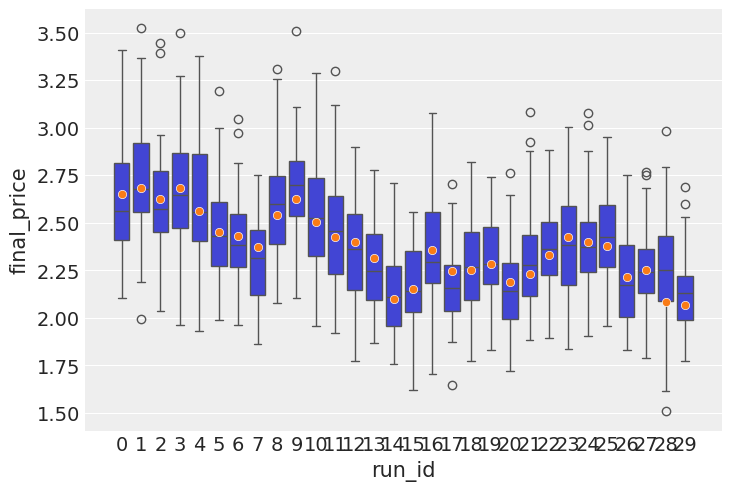

In [14]:
sns.boxplot(data=all_lasts, x="run_id", y="final_price")
sns.scatterplot(data=actual_prices, x="run_id", y="actual_price", zorder=10)
# plt.ylim([0, 200])

We can finally see that the mean error on the observed values is 25% lower than in the previous version.

In [44]:
all_lasts.join(
    actual_prices, left_on="run_id", right_on="run_id", how="left"
).with_columns(error=(pl.col("final_price") - pl.col("actual_price")) ** 2).group_by(
    "run_id"
).agg(pl.col("error").mean())["error"].mean()

0.06851477431434409

## Option pricing

Next, we calculate the call option payoff distributions, as well as model-implied option prices.

<Axes: xlabel='final_price', ylabel='Count'>

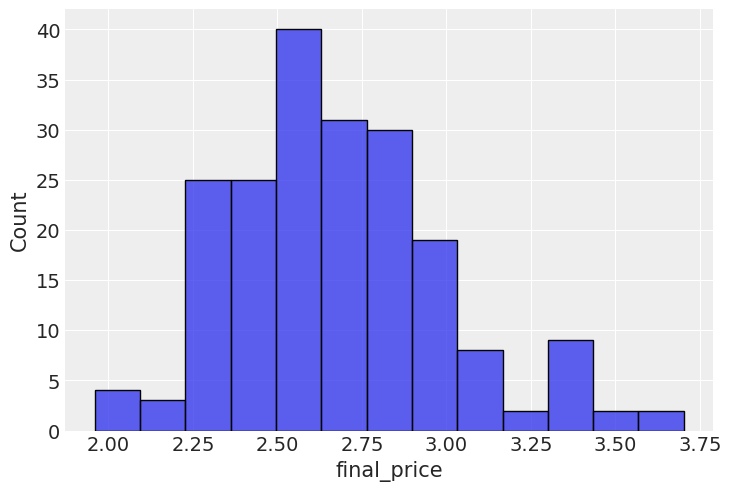

In [15]:
last_prices = (
    all_runs.sort("date")  # Ensure dates are in correct order
    .group_by("run_id")
    .agg(pl.col("price").last())  # Get the last price for each run
    .rename({"price": "final_price"})
)
sns.histplot(last_prices, x="final_price")

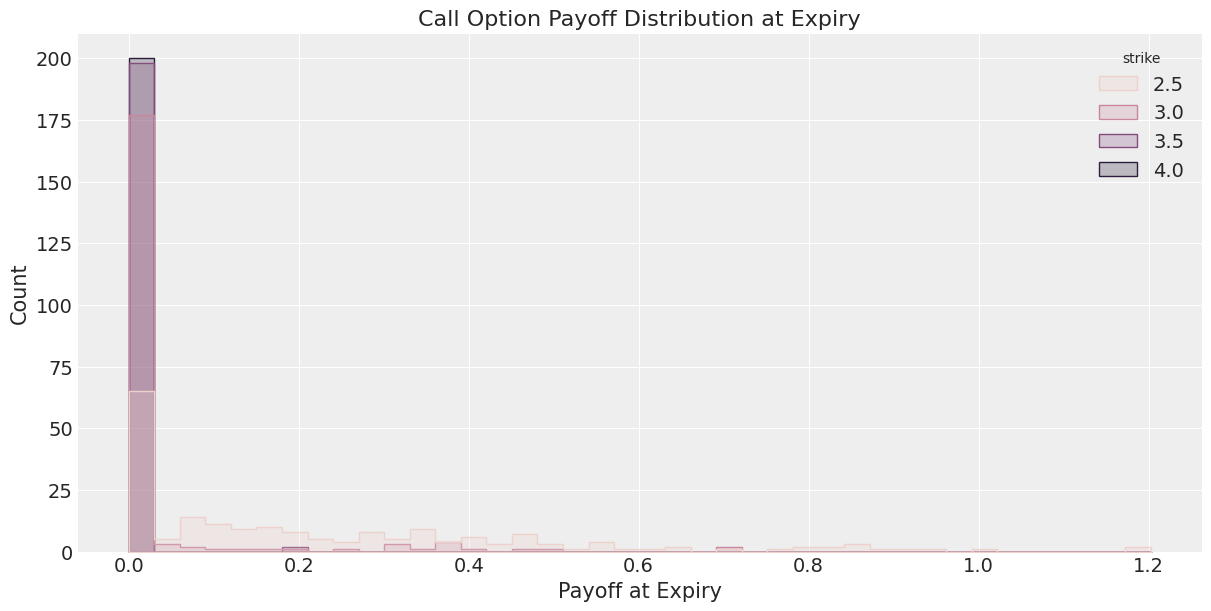

In [16]:
strike_prices = [2.5, 3.0, 3.5, 4.0]

# Create a list of DataFrames, one per strike
payoff_dfs = [
    last_prices.with_columns(
        payoff_at_expiry=(pl.col("final_price") - strike).clip(0),
        strike=pl.lit(strike),  # so we can track which row belongs to which strike
    )
    for strike in strike_prices
]

# Concatenate into one big DataFrame
payoff_df_all = pl.concat(payoff_dfs)
plt.figure(figsize=(12, 6))
sns.histplot(
    data=payoff_df_all,
    x="payoff_at_expiry",
    hue="strike",
    element="step",
    stat="count",
    bins=40,
)
plt.title("Call Option Payoff Distribution at Expiry")
plt.xlabel("Payoff at Expiry")
plt.ylabel("Count")
plt.grid(True)
plt.show()

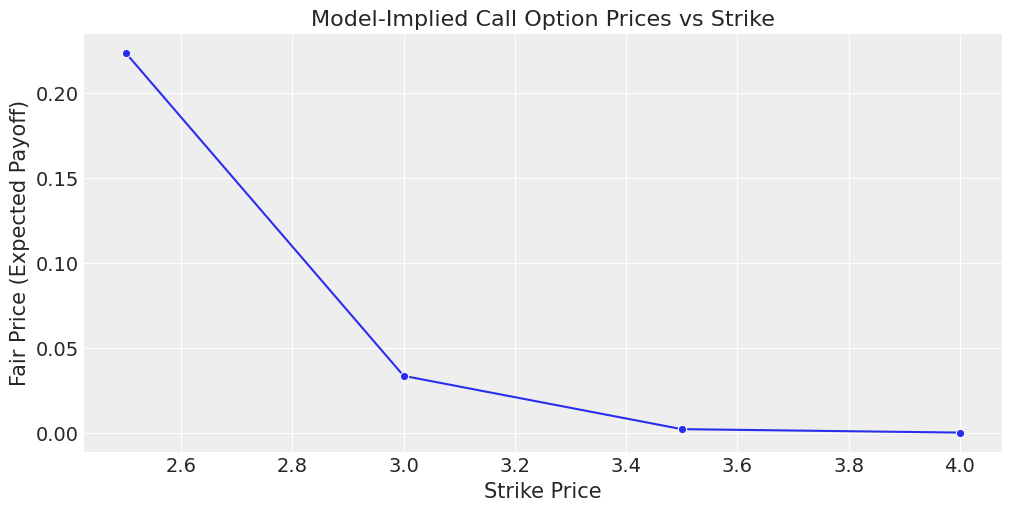

In [17]:
# Group and average payoff per strike
implied_prices = payoff_df_all.group_by("strike").agg(pl.col("payoff_at_expiry").mean())

# Plot the pricing curve
plt.figure(figsize=(10, 5))
sns.lineplot(data=implied_prices, x="strike", y="payoff_at_expiry", marker="o")
plt.title("Model-Implied Call Option Prices vs Strike")
plt.xlabel("Strike Price")
plt.ylabel("Fair Price (Expected Payoff)")
plt.grid(True)
plt.show()

In this post I have implemented a latent volatility model, which has a measurable improvement in predictive power for future price scenarios. In the next post I will demonstrate how energy commodities storage levels can be incorporated into this model.



## Limitations & Next Steps

* The model assumes latent volatility follows a stationary process, which may not hold in extreme market events.
* Does not yet incorporate external factors (e.g., inventory levels, macro data).
* Model not benchmarked against market-implied volatility surfaces.
* Future work: extend to multivariate commodities or test on real-world options datasets.
* This is a research-grade toy model; do not use for actual trading decisions.

## Further reading

* [Previous article: A Bayesian GARCH-Inspired Volatility Model for Energy Commodities Option Pricing](garch_like_modelling.html)
* [Original GARCH paper](https://public.econ.duke.edu/~boller/Published_Papers/joe_86.pdf)
* [NumPyro docs](https://num.pyro.ai/en/latest/index.html#introductory-tutorials)